In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.python.framework import ops
import math
import matplotlib.pyplot as plt

In [2]:
# Convert to UTF-8 as follows:
# iconv -c -f ASCII -t UTF-8 < Trade_DetailedTradeMatrix_E_All_Data_\(Normalized\).csv > trade.csv &

trade_raw = pd.read_csv('Sean/Data/trade.csv')
food_balance_raw = pd.read_csv('Sean/Data/balance.csv')
food_supply_raw = pd.read_csv('Sean/Data/supply.csv')
food_production_raw = pd.read_csv('Sean/Data/production.csv')
malnutrition_raw = pd.read_csv('Sean/Data/malnutrition.csv')
population_raw = pd.read_csv('Sean/Data/population.csv')

/Users/sean/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (0,2,4,6,7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [465]:
# CONSTANTS
PREDICTION_LENGTH = 1
np.random.seed(1)

In [466]:
# Filter Food Production to only include production (Element Code 5510, tonnes)
# food_production_unaggregated = food_production_raw.loc[:,['Area Code','Item Code','Element Code','Year Code','Value']].loc[food_production_raw['Element Code']==5510].drop(columns=['Element Code']).apply(pd.to_numeric, errors='ignore')
# Filter Food Supply to only include Food Supply Quantity (Element Code 641, tonnes)
# food_supply = food_supply_raw.loc[:,['Area Code','Item Code','Element Code','Year Code','Value']].loc[food_supply_raw['Element Code']==641].drop(columns=['Element Code']).apply(pd.to_numeric, errors='ignore')
# Filter Trade to only include export quantity (Element Code 5910, tonnes) and import quantity (Element Code 5610, tonnes)
# Note that reporter and partner quantity may not agree (http://fenixservices.fao.org/faostat/static/documents/TM/TM_e.pdf)
# Thus only count imports and exports with respect to the reporting country.  That's what matter for actual balance.
# trade_export_unaggregated = trade_raw.loc[:,['Reporter Country Code','Item Code','Element Code','Year Code','Value']].loc[trade_raw['Element Code']==5910].rename(columns={'Reporter Country Code':'Area Code'}).drop(columns=['Element Code']).apply(pd.to_numeric, errors='ignore')
# trade_import_unaggregated = trade_raw.loc[:,['Reporter Country Code','Item Code','Element Code','Year Code','Value']].loc[trade_raw['Element Code']==5610].rename(columns={'Reporter Country Code':'Area Code'}).drop(columns=['Element Code']).apply(pd.to_numeric, errors='ignore')
# Filter Population to only include Total Population- both sexes (Element Code 511, 1000 persons) -> need to multiply by 1000 to get number of people
# population = population_raw.loc[:,['Area Code','Year Code','Value','Element Code']].loc[population_raw['Element Code']==511].rename(columns={'Value': 'Population'}).drop(columns=['Element Code']).apply(pd.to_numeric, errors='ignore')
# population.loc[:,['Population']] = population.loc[:,['Population']].values * 1000.

In [467]:
# Instead of accumulated trade, supply, and population data, use the balance data.  The UN already has accounted for the issues we are facing.

# Filter Food Balance to only include food available for consumption (Element Code 5142, 1000 tonnes)
food_balance = food_balance_raw.loc[:,['Area','Item','Area Code','Item Code','Element Code','Year Code','Value']].loc[food_balance_raw['Element Code']==5301].drop(columns=['Element Code']).apply(pd.to_numeric, errors='ignore')
food_balance = food_balance.rename(columns={'Value':'Total Food Balance'})
# For export, use Element Code 5911
trade_export = food_balance_raw.loc[:,['Area Code', 'Item Code', 'Element Code', 'Year Code', 'Value']].loc[food_balance_raw['Element Code']==5911].drop(columns=['Element Code']).apply(pd.to_numeric, errors='ignore')
trade_export = trade_export.rename(columns={'Value':'Amount Exported'})
# For import, use Element Code 5611
trade_import = food_balance_raw.loc[:,['Area Code', 'Item Code', 'Element Code', 'Year Code', 'Value']].loc[food_balance_raw['Element Code']==5611].drop(columns=['Element Code']).apply(pd.to_numeric, errors='ignore')
trade_import = trade_import.rename(columns={'Value':'Amount Imported'})
# For production, use Element Code 5511
food_production = food_balance_raw.loc[:,['Area Code', 'Item Code', 'Element Code', 'Year Code', 'Value']].loc[food_balance_raw['Element Code']==5511].drop(columns=['Element Code']).apply(pd.to_numeric, errors='ignore')
food_production = food_production.rename(columns={'Value':'Amount Produced'})
# For population, use Element Code 511
population = food_balance_raw.loc[:,['Area Code', 'Element Code', 'Year Code', 'Value']].loc[food_balance_raw['Element Code']==511].drop(columns=['Element Code']).apply(pd.to_numeric, errors='ignore')
population = population.rename(columns={'Value':'Population'})
# For feed, use Element Code 5521
food_for_livestock = food_balance_raw.loc[:,['Area Code', 'Item Code', 'Element Code', 'Year Code', 'Value']].loc[food_balance_raw['Element Code']==5521].drop(columns=['Element Code']).apply(pd.to_numeric, errors='ignore')
food_for_livestock = food_for_livestock.rename(columns={'Value':'Food for Livestock'})
# For seed, use Element Code 5527
food_for_plants = food_balance_raw.loc[:,['Area Code', 'Item Code', 'Element Code', 'Year Code', 'Value']].loc[food_balance_raw['Element Code']==5527].drop(columns=['Element Code']).apply(pd.to_numeric, errors='ignore')
food_for_plants = food_for_plants.rename(columns={'Value':'Food for Plants'})
# For people food, use Element Code 5142
food_for_people = food_balance_raw.loc[:,['Area Code', 'Item Code', 'Element Code', 'Year Code', 'Value']].loc[food_balance_raw['Element Code']==5142].drop(columns=['Element Code']).apply(pd.to_numeric, errors='ignore')
food_for_people = food_for_people.rename(columns={'Value':'Food for People'})
# For losses, use Element Code 5123
losses = food_balance_raw.loc[:,['Area Code', 'Item Code', 'Element Code', 'Year Code', 'Value']].loc[food_balance_raw['Element Code']==5123].drop(columns=['Element Code']).apply(pd.to_numeric, errors='ignore')
losses = losses.rename(columns={'Value':'Losses'})


In [468]:
# DEBUG - only consider the USA
# food_production_unaggregated = food_production_unaggregated.loc[food_production_unaggregated['Area Code']==231]
# food_supply = food_supply.loc[food_supply['Area Code']==231]
# food_balance = food_balance.loc[food_balance['Area Code']==231]
# trade_unaggregated = trade_unaggregated.loc[(trade_unaggregated['Area Code']==231)]
# DEBUG - only consider the USA

In [469]:
# FAO aggregates products for Food Balance and Food Supply
# Food Production and Trade is not aggregated
# In order to compare the datasets, Food Production and Trade must be aggregated using the aggregate mapping
# The aggregate mapping requires pre-processing
# aggregate_mapping_raw = pd.read_csv('Sean/Data/aggregate-mapping.csv').loc[:,['Item Code', 'Description']].rename(columns={'Item Code':'Aggregate Item Code'})
# aggregate_index_mapping = aggregate_mapping_raw.Description.str.extractall('(\d+)').reset_index().drop(columns=['match']).rename(columns={0:'Item Code'}).rename(columns={'level_0':'Aggregated Item Code Index'})
# aggregate_mapping = pd.merge(left=aggregate_mapping_raw,
#                              right=aggregate_index_mapping,
#                              how='outer',
#                              left_index=True,
#                              right_on=['Aggregated Item Code Index']).dropna().drop(columns=['Aggregated Item Code Index','Description']).apply(pd.to_numeric, errors='ignore')

In [470]:

# Aggregate the Food Production and Trade dataframes
# food_production = pd.merge(left=food_production_unaggregated,
#                                       right=aggregate_mapping,
#                                       how='inner',
#                                       on='Item Code').drop(columns=['Item Code']).rename(columns={'Aggregate Item Code':'Item Code'})
# trade_import = pd.merge(left=trade_import_unaggregated,
#                             right=aggregate_mapping,
#                             how='inner',
#                             on='Item Code').drop(columns=['Item Code']).rename(columns={'Aggregate Item Code':'Item Code'})
# trade_export = pd.merge(left=trade_export_unaggregated,
#                             right=aggregate_mapping,
#                             how='inner',
#                             on='Item Code').drop(columns=['Item Code']).rename(columns={'Aggregate Item Code':'Item Code'})

In [471]:
# Given [country, year, item code, element code]
# Predict [future balance]
# From [supply, amount traded out, amount traded in]

# Create new prediction_data dataframe from food_supply dataframe
prediction_data = food_balance.copy().rename(columns={'Value':'Current Balance'})
print(len(prediction_data))

1144776


In [472]:
# Filter by summing [Value] for a constant [Area Code, Item Code, Year Code]
# trade_export = trade_export.groupby(['Area Code', 'Item Code', 'Year Code'])[['Value']].sum().reset_index()
# Rename the [Value] column of trade_export to be [Amount Exported]
# trade_export = trade_export.rename(columns={'Value': 'Amount Exported'})
# Merge trade_export with prediction_data on [Area Code, Item Code, Year Code]
prediction_data = pd.merge(left=prediction_data,
                           right=trade_export,
                           how='inner',
                           on=['Area Code', 'Item Code', 'Year Code'])
print(len(prediction_data))

958412


In [473]:
# Filter by summing [Value] for a constant [Area Code, Item Code, Year Code]
# trade_import = trade_import.groupby(['Area Code', 'Item Code', 'Year Code'])[['Value']].sum().reset_index()
# Rename the [Value] column of trade_import to be [Amount Exported]
# trade_import = trade_import.rename(columns={'Value': 'Amount Imported'})
# Merge trade_import with prediction_data on [Area Code, Item Code, Year Code]
prediction_data = pd.merge(left=prediction_data,
                           right=trade_import,
                           how='inner',
                           on=['Area Code', 'Item Code', 'Year Code'])
print(len(prediction_data))

942433


In [474]:
# Rename the [Value] column of food_production to be [Amount Produced]
# food_production = food_production.rename(columns={'Value': 'Amount Produced'})
# Merge food_balance with prediction_data on [Area Code, Item Code, 'Year Code']
prediction_data = pd.merge(left=prediction_data,
                          right=food_production,
                          how='inner',
                          on=['Area Code','Item Code','Year Code'])
print(len(prediction_data))

715445


In [475]:
# Insert population into the prediction_data
prediction_data = pd.merge(left=prediction_data,
                          right=population,
                          how='left',
                          on=['Area Code','Year Code'])
print(len(prediction_data))

715445


In [476]:
# Insert population into the prediction_data
prediction_data = pd.merge(left=prediction_data,
                          right=food_for_livestock,
                          how='inner',
                          on=['Area Code','Item Code','Year Code'])
print(len(prediction_data))

226020


In [477]:
# Insert population into the prediction_data
prediction_data = pd.merge(left=prediction_data,
                          right=food_for_plants,
                          how='inner',
                          on=['Area Code','Item Code','Year Code'])
print(len(prediction_data))

114382


In [478]:
# Insert population into the prediction_data
prediction_data = pd.merge(left=prediction_data,
                          right=food_for_people,
                          how='inner',
                          on=['Area Code','Item Code','Year Code'])
print(len(prediction_data))

108521


In [479]:
# Insert population into the prediction_data
prediction_data = pd.merge(left=prediction_data,
                          right=losses,
                          how='inner',
                          on=['Area Code','Item Code','Year Code'])
print(len(prediction_data))

97985


In [480]:
future_people_food = food_for_people.copy()
# Translate the food_balance out PREDICTION_LENGTH years
future_people_food.loc[:,['Year Code']] = future_people_food.loc[:,['Year Code']].values - PREDICTION_LENGTH
# Rename the [Value] column of food_balance to be [Predicted Value]
future_people_food = future_people_food.rename(columns={'Food for People': 'Predicted Food for People'})
# Merge food_balance with prediction_data on [Area Code, Item Code, 'Year Code']
prediction_data = pd.merge(left=prediction_data,
                          right=future_people_food,
                          how='inner',
                          on=['Area Code','Item Code','Year Code'])
print(len(prediction_data))

95896


In [481]:
# Input Data Columns: [Year Code, Item Code, Current Supply, Amount Produced, Amount Exported, Amount Imported, Population]
# Predicted Data Columns: [Predicted Balance]
prediction_data = prediction_data.dropna()
print(len(prediction_data))

95896


In [482]:
# create train and test datasets
X = prediction_data.loc[:,['Item Code', 'Total Food Balance', 'Amount Exported', 'Amount Imported', 'Amount Produced', 'Population', 'Food for Livestock', 'Food for Plants', 'Food for People', 'Losses', 'Predicted Food for People']].sample(frac=1, axis=0)
Y = X.loc[:,'Predicted Food for People']
m = X.shape[0]
Y_train = Y[int(m*.1):m-1]
Y_test = Y[0:int(m*.1)]
X_train = X[int(m*.1):m-1]
X_test = X[0:int(m*.1)]
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std
X_train = X_train.drop(columns=['Predicted Food for People']).values.T
Y_train = Y_train.values.T.reshape(1,-1)
X_test = X_test.drop(columns=['Predicted Food for People']).values.T
Y_test = Y_test.values.T.reshape(1,-1)

In [483]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    
    if mini_batch_size > m:
        mini_batches.append((X,Y))
    else:
        # Step 1: Shuffle (X, Y)
        permutation = list(np.random.permutation(m))
        shuffled_X = X[:, permutation]
        shuffled_Y = Y[:, permutation].reshape((1,m))

        # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
        num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
        for k in range(0, num_complete_minibatches):
            ### START CODE HERE ### (approx. 2 lines)
            mini_batch_X = shuffled_X[:, k*mini_batch_size: (k+1)*(mini_batch_size)]
            mini_batch_Y = shuffled_Y[:, k*mini_batch_size: (k+1)*(mini_batch_size)]
            ### END CODE HERE ###
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)

        # Handling the end case (last mini-batch < mini_batch_size)
        if m % mini_batch_size != 0:
            ### START CODE HERE ### (approx. 2 lines)
            mini_batch_X = shuffled_X[:, int(mini_batch_size*np.floor(m/mini_batch_size)): m]
            mini_batch_Y = shuffled_Y[:, int(mini_batch_size*np.floor(m/mini_batch_size)): m]
            ### END CODE HERE ###
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
    
    return mini_batches

In [487]:
def model(X_train,
          Y_train,
          X_test,
          Y_test,
          learning_rate = 0.0001,
          num_epochs = 1500,
          minibatch_size = 64,
          print_cost = True):
    ops.reset_default_graph()
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    costs = []
    
    X = tf.placeholder(tf.float32, shape=(n_x,None), name='X')
    Y = tf.placeholder(tf.float32, shape=(1,None), name='X')
    
    W1 = tf.get_variable('W1', (10,n_x), initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable('b1', (10,1), initializer=tf.zeros_initializer())
    W2 = tf.get_variable('W2', (1,10), initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable('b2', (1,1), initializer=tf.zeros_initializer())
    W3 = tf.get_variable('W3', (1,10), initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable('b3', (1,1), initializer=tf.zeros_initializer())
    W4 = tf.get_variable('W4', (10,10), initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b4 = tf.get_variable('b4', (10,1), initializer=tf.zeros_initializer())
    W5 = tf.get_variable('W5', (10,10), initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b5 = tf.get_variable('b5', (10,1), initializer=tf.zeros_initializer())
    W6 = tf.get_variable('W6', (1,10), initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b6 = tf.get_variable('b6', (1,1), initializer=tf.zeros_initializer())

    parameters = {'W1':W1,
                 'b1':b1,
                 'W2':W2,
                 'b2':b2,
                 'W3':W3,
                 'b3':b3,
                 'W4':W4,
                 'b4':b4,
                 'W5':W5,
                 'b5':b5,
                 'W6':W6,
                 'b6':b6}
    
    Z1 = W1@X+b1
    A1 = tf.nn.relu(Z1)
    Z2 = W2@A1+b2
    A2 = tf.nn.relu(Z2)
#     Z3 = W3@A2+b3
#     A3 = tf.nn.relu(Z3)
#     Z4 = W4@A3+b4
#     A4 = tf.nn.relu(Z4)
#     Z5 = W5@A4+b5
#     A5 = tf.nn.relu(Z5)
#     Z6 = W6@A5+b6
#     A6 = tf.nn.relu(Z6)

    cost = tf.sqrt(tf.reduce_mean((A2-Y)**2))
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

    init = tf.global_variables_initializer()
    
    seed = 3
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            if num_minibatches < 1: num_minibatches=1
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost / num_minibatches
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.abs(1-A2/Y) < 0.2

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        #print(sess.run(W1))

Cost after epoch 0: 36739.699219
Cost after epoch 100: 30911.863281
Cost after epoch 200: 18880.878906
Cost after epoch 300: 16731.308594
Cost after epoch 400: 14046.434570
Cost after epoch 500: 10645.580078
Cost after epoch 600: 7459.853516
Cost after epoch 700: 4935.082520
Cost after epoch 800: 2629.014160
Cost after epoch 900: 1151.010132
Cost after epoch 1000: 1011.019043
Cost after epoch 1100: 998.727661
Cost after epoch 1200: 994.009705
Cost after epoch 1300: 991.852539
Cost after epoch 1400: 990.621277


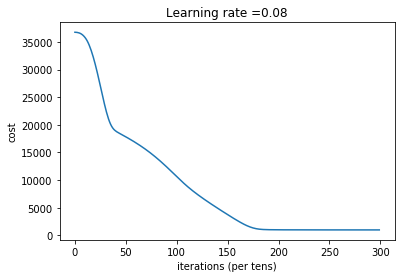

Parameters have been trained!
Train Accuracy: 0.61381596
Test Accuracy: 0.6116383


In [488]:
model(X_train, Y_train, X_test, Y_test, learning_rate=0.08, minibatch_size=10000000)

In [374]:
from tensorflow import keras

def build_model():
  model = keras.Sequential([
    keras.layers.Dense(10, activation=tf.nn.relu,
                       input_shape=(X_train.shape[0],)),
    keras.layers.Dense(10, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_10 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________


In [376]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

# Store training stats
history = model.fit(X_train.T, Y_train.T, epochs=100,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................

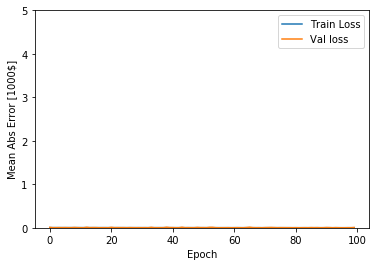

In [377]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [1000$]')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0, 5])

plot_history(history)